In [1]:
#Uncomment this line if you are connecting to Google Drive to access the files
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#Uncomment this line and execute if you get the error that the transformers package has not been installed
#pip install transformers

In [3]:
#Code to change the current working directory to where the input files are
import os
#os.chdir('/content/drive/MyDrive/Sussex - MSc Data Science/Term 2/Advanced NLP/Assignment')

# **Import Standard Libraries**

In [4]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
seed = 260758
random.seed(seed)

import nltk
import gensim
import gensim.downloader as api
from sklearn.metrics import classification_report
import torch.optim as optim
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import spacy
import string
from sklearn import metrics

import torch
import numpy as np
from torch import nn
from transformers import BertTokenizer, BertModel
from torch.optim import Adam
from tqdm import tqdm
import gc

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
#Set seed to ensure the code and outputs are reproducible
torch.manual_seed(seed)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

In [8]:
#Clear CUDA cache to free up memory
torch.cuda.empty_cache()

In [9]:
#Check if NVIDIA GPU is available
#If yes, use CUDA to perform computations
use_cuda = torch.cuda.is_available()

if use_cuda:
    print("GPU acceleration enabled")
else:
    print("GPU acceleration NOT enabled. If using Colab, have you changed the runtime type and selected GPU as the hardware accelerator?")

device = torch.device("cuda" if use_cuda else "cpu")
print(device)

GPU acceleration enabled
cuda


# Read in training and validation datasets

In [10]:
df_train_input = pd.read_csv('propaganda_dataset_v2/propaganda_train.tsv', sep='\t')
df_train_input['label'] = df_train_input['label'].str.strip()
df_train_input['tagged_in_context'] = df_train_input['tagged_in_context'].str.strip()
print(f'No. of records in the training dataset:{df_train_input.count()}')
df_train_input = df_train_input.sample(frac=1)
df_train_input

No. of records in the training dataset:label                2414
tagged_in_context    2414
dtype: int64


,label,tagged_in_context
1068,causal_oversimplification,<BOS> Democrats want to delay this vote until ...
7,not_propaganda,<BOS> Kirstjen Nielsen (@SecNielsen) <EOS> Nov...
1892,causal_oversimplification,"As I've said before, I don't support Kavanaugh..."
1807,not_propaganda,<BOS> If the equation doesn’t come out in the ...
1144,repetition,We’re doing everything in <BOS> our <EOS> powe...
...,...,...
1652,not_propaganda,The outbreak of the contagious and <BOS> deadl...
1753,not_propaganda,<BOS> The frontal attacks have been coming not...
2217,not_propaganda,DB: And <BOS> who can forget the release <EOS>...
1721,not_propaganda,Glenn <BOS> Greenwald noted that the Ecuadoria...


In [11]:
df_validation = pd.read_csv('propaganda_dataset_v2/propaganda_val.tsv', sep='\t')
df_validation['label'] = df_validation['label'].str.strip()
df_validation['tagged_in_context'] = df_validation['tagged_in_context'].str.strip()
df_validation = df_validation.sample(frac=1)
print(f'No. of records in the validation dataset:{df_validation.count()}')
df_validation

No. of records in the validation dataset:label                580
tagged_in_context    580
dtype: int64


,label,tagged_in_context
290,loaded_language,"At this point, continued pleading for a Bergog..."
449,flag_waving,“It’s time for our leaders in Washington to fo...
131,"name_calling,labeling","Bob Mueller is totally conflicted, and <BOS> h..."
308,causal_oversimplification,<BOS> If you think Mrs. Ford is ignorant of th...
487,not_propaganda,Why are we now in this very sad <BOS> situatio...
...,...,...
320,not_propaganda,“Let us beg forgiveness for our own sins and t...
225,doubt,<BOS> The US Is Blatantly Telling Lies <EOS>
194,not_propaganda,The woman’s lifeless body can be seen being dr...
535,not_propaganda,"Jesus said, ""Think not that I am come to destr..."


For binary classification, we do not need the specific type of propangada label. Instead we need to just distinguish if its an instance of propaganda or not. I will create a new field to be used for the binary classification task.

In [12]:
df_train_input['binary_label'] = np.where(df_train_input['label']!='not_propaganda', 'propaganda', df_train_input['label'])
df_validation['binary_label'] = np.where(df_validation['label']!='not_propaganda', 'propaganda', df_validation['label'])

## **Check the distribution of Training data**

<Axes: xlabel='label'>

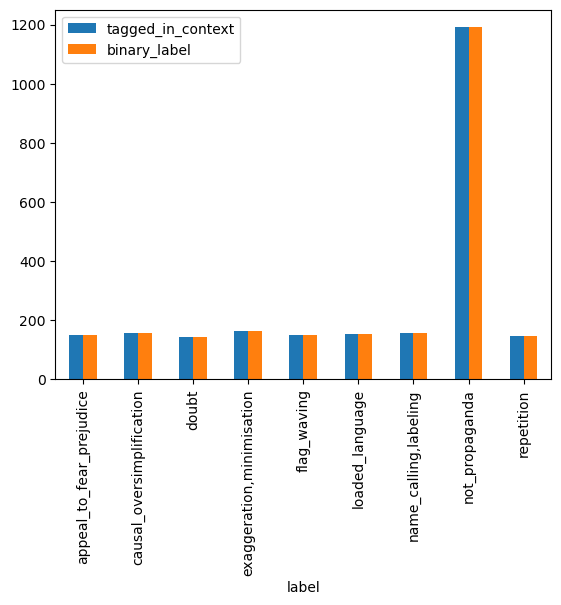

In [13]:
df_train_input.groupby('label').count().plot(kind='bar')

In [14]:
df_train_input.groupby('binary_label').count()

,label,tagged_in_context
binary_label,,
not_propaganda,1191,1191
propaganda,1223,1223


<Axes: xlabel='label'>

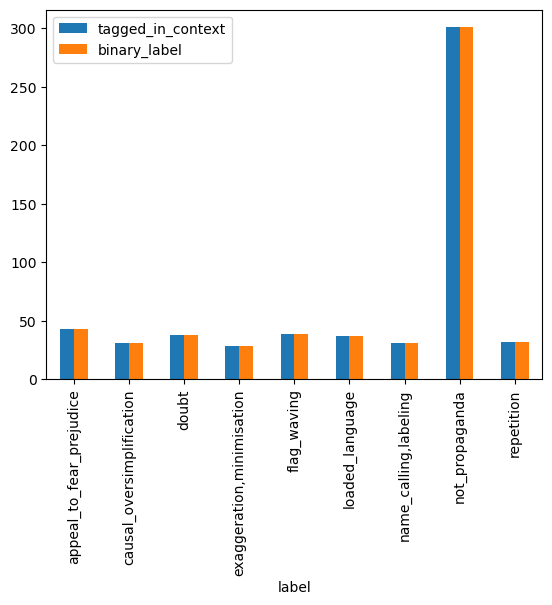

In [15]:
df_validation.groupby('label').count().plot(kind='bar')

The training dataset is balanced when we consider the binary classification task (Task 1). This is a binary classification task since we only have to predict if the text belongs to the class - 'propaganda' or 'not_propaganda', i.e. only 2 distinct outputs.

For multiclass classification (Task 2), the dataset is balanced because we only have to consider text containing propaganda and predict the type of propaganda in the text. Therefore, we can remove the 'not_propaganda' rows which makes the dataset balanced.


I will now split the training dataset into a separate train and test dataset. The testing dataset will contain 20% of the data currently in the training class.

In [16]:
#Split the data into train and test sets.
df_train, df_test = train_test_split(df_train_input, test_size=0.2, random_state=seed)
df_test

,label,tagged_in_context,binary_label
2057,doubt,Las Vegas police said Friday that the gunman w...,propaganda
2161,not_propaganda,Murillo wrote at the outset of the lengthy <BO...,not_propaganda
1640,not_propaganda,If <BOS> they are aware that the Church has up...,not_propaganda
920,not_propaganda,The admission of public adulterers in “second ...,not_propaganda
1599,"exaggeration,minimisation",In case Kim didn’t remember the dire fate of I...,propaganda
...,...,...,...
2128,"exaggeration,minimisation",<BOS> Gun Control Is Now Truly Impossible <EOS>,propaganda
1224,causal_oversimplification,"<BOS> These actions, committed by more than a ...",propaganda
600,not_propaganda,With the lifting of the nuclear-related sancti...,not_propaganda
845,loaded_language,"The sum of all this has been, as in many other...",propaganda


# **Task 1 - Binary Classification**

In [17]:
#Select the required columns
df_train_binary_classification = df_train[['tagged_in_context', 'binary_label']].copy()
df_test_binary_classification = df_test[['tagged_in_context', 'binary_label']].copy()
df_validation_binary_classification = df_validation[['tagged_in_context', 'binary_label']].copy()

In [18]:
#Binary Classification labels
binary_labels = {label:i for i,label in enumerate(df_train_binary_classification['binary_label'].sort_values().unique().tolist())}
binary_labels

{'not_propaganda': 0, 'propaganda': 1}

In [19]:
#Build a reverse index dictionary for easy lookup.
reverse_index_binary_label ={v:k for (k,v) in binary_labels.items()}
reverse_index_binary_label

{0: 'not_propaganda', 1: 'propaganda'}

**For Task 1 - I will be creating 2 text classifiers**

**1) GloVe Binary Classifier -** This classifier will use the pretained glove-wiki-gigaword-300 word embeddings to encode the
text strings as a sentence vector, which will then be passed onto a simple 2-layer Neural Network to perform the classification

**2) BERT Binary Classifier** - This classifier will use the pretrained 'bert-base-uncased' model to convert the strings into word embeddings which will then be fed into a simple Neural Network for binary classification

## **Task 1.1 GloVe Classifier**



In [20]:
#Print out the list of pre-trained glove/word2vec embeddings.
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [21]:
wv = api.load('glove-wiki-gigaword-300')

In [22]:
#If the code throws an error due to the 'en_core_web_sm' package being unavailable on your system/Google Colab, uncomment this code and run
#!python -m spacy download en_core_web_sm

In [23]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
punctuations = string.punctuation


def sentenceVector(sentence):
    """
    This is a function to loop over every word in a given sentence and find out the vector representation of the word 
    in the glove-wiki-gigaword-300 pre-trained vector.
    
    Input Parameters: 
    sentence: A list of words in a given sentence
    
    Output Parameters:
    vectorResult: The vector representation of the string.
    """
    vectorSize = wv.vector_size
    vectorResult = np.zeros(vectorSize)
    counter = 1
    for word in sentence:
        if word in wv:
            counter += 1
            vectorResult += wv[word]
    vectorResult = vectorResult / counter
    return vectorResult

def spacyTokenizer(sentence):
    """
    This is a function to tokenize the words in a given sentence by using the pre-trained 'en_core_web_sm' model,
    lemmatize each token and filter out the stopwords and punctuations in the sentence.
    
    Input Parameters:
    sentence: A list of words or a string contained a list of words
    
    Output Parameters: 
    filteredTokens: Tokenized, lemmatized and filtered list of tokens.
    """
    # Load the pre-trained spaCy model
    doc = nlp(sentence)

    # Lemmatize each token and convert each token into lowercase
    lemmatizedTokens = [word.lemma_.lower().strip() for word in doc]

    # Remove stop words and punctuations
    filteredTokens = [word for word in lemmatizedTokens if word not in stop_words and word not in punctuations]

    # Return preprocessed list of tokens
    return filteredTokens

In [24]:
#Code for a Dataset class
#Adapted from the Advanced NLP Lab 6 Solutions Notebook
class GloveEmbeddedBinaryDataset(torch.utils.data.Dataset):
    """
    This class defines a Dataset that will be used to load the prepare the data for training, validation and testing
    """
    def __init__(self, df, label_dict, column='tagged_in_context'):
        self.labels = [label_dict[label] for label in df['binary_label']]
        self.texts = [torch.from_numpy(np.array(sentenceVector(spacyTokenizer(text))).astype(np.float32)) for text in df[column]]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        
        return batch_texts, batch_y

In [25]:
#Load the training, validation and testing datasets
glove_binary_training_df = GloveEmbeddedBinaryDataset(df_train_binary_classification, binary_labels)
glove_binary_testing_df = GloveEmbeddedBinaryDataset(df_test_binary_classification, binary_labels)
glove_binary_validation_df = GloveEmbeddedBinaryDataset(df_validation_binary_classification, binary_labels)

In [26]:
# Define the neural network architecture
#Adapted from the Advanced NLP Lab 6 Solutions Notebook
class BinaryClassifierNet(nn.Module):
    """
    Code adapted from Advanced NLP Week 6 Lab solutions.
    This class will define the structure of the neural network used for classification.
    It also defines how the output from one layer will be propagated to the next.
    
    Input Parameters:
    input_size: The size of the input data
    hidden_size: The number of hidden layers to be defined in the Neural Network architecture.
    output_size: The expected number of outputs, labels in the dataset.
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(BinaryClassifierNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        #x = nn.functional.sigmoid(x)
        return x

In [27]:
#Create a GloVe Binary text classification model for propaganda detection.
INPUT_SIZE = 300
HIDDEN_SIZE = 150
OUTPUT_SIZE = 2

gloveBinaryClassifier = BinaryClassifierNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

In [28]:
#Adapted from the Advanced NLP Lab 6 Solutions Notebook
def train_GloveBinaryClassifier(model, train_data,val_data,learning_rate,epochs):
    """
    Adapted from the Advanced NLP Lab 6 Solutions Notebook
    This function is responsible for training the GloVeBinaryClassifier on the input data. 
    This will orchestrate loss calculation, backpropagation, evaluation, learning rate
    
    Input Parameters:
    model: The instance of the model class to be used for training
    train_data: The training 'Dataset' (instance) to be used for training the model
    val_data: The validation 'Dataset' (instance) to be used for model validation.
    learning_rate: The value that specifies how the model parameters are updated with each iteration
    epochs: The number of iterations to be performed during training.
    
    Outputs:
    None
    Prints the Training iteration, training loss and validation loss
    """
    
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=2)
    
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    
    criterion=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=learning_rate)
    
    if use_cuda:
        model=model.cuda()
        criterion=criterion.cuda()
        
    for epoch_num in range(epochs):
        total_acc_train=0
        total_loss_train=0
        model.train()
        for train_input,train_label in tqdm(train_dataloader):
            
            train_input = train_input.cuda()
            train_label = train_label.cuda()
            output=model(train_input.cuda())
            
            batch_loss=criterion(output,train_label.long())
            total_loss_train +=batch_loss.item()
            
            acc=(output.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc
            
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        total_acc_val=0
        total_loss_val=0
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:
                
                val_input = val_input.cuda()
                val_label = val_label.cuda()
                
                output=model(val_input)
                
                batch_loss=criterion(output,val_label.long())
                
                total_loss_val+=batch_loss.item()
                
                acc=(output.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc
                
        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')    

In [29]:
#Adapted from the Advanced NLP Lab 6 Solutions Notebook
batchsize=4
def evaluate_GloveBinaryClassifier(model,test_dataset,batchsize=4):
    """
    Code adapted from Advanced NLP Week 6 Lab Solutions
    This function is responsible for evaluating the model on previously unseen test data(data not used in training/validation)
    
    Input Parameters:
    model: The instance of the model class for which evaluation needs to be performed.
    test_dataset: The test dataset to be used for testing out to use to perform evaluation of the model
    
    Outputs:
    predictions: An array of tensors containing the predictions of the model for each data point in the training dataset
    acc: The total accuracy of the model.
    """
    model.eval()
    test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batchsize)
    
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    
    if use_cuda:
        model=model.cuda()
        
    total_acc_test=0
    with torch.no_grad():
        count=0
        predictions=[]
        for test_input,test_label in tqdm(test_dataloader):
            count+=batchsize
            test_input=test_input.to(device)
            test_label=test_label.to(device)
            output=model(test_input)
            #print(output.argmax(dim=1),test_label)
            predictions.append(output.argmax(dim=1))  #save the prediction for further analysis
            acc=(output.argmax(dim=1)==test_label).sum().item()
            
            total_acc_test+=acc
            if count%100==0:
                print(f'Accuracy so far = {total_acc_test/count: .3f}')
            
    print(f'Test accuracy: {total_acc_test/len(test_dataset): .3f}')
    return predictions, (total_acc_test/len(test_dataset))

In [30]:
#Instantiate the GloVe based binary classifier.
EPOCHS=5
LR=1e-04
gloveBinaryClassifier = BinaryClassifierNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

In [31]:
#Train the GloveBinaryClassifier
train_GloveBinaryClassifier(gloveBinaryClassifier,glove_binary_training_df,glove_binary_validation_df,LR,EPOCHS)

100%|██████████| 966/966 [00:07<00:00, 133.51it/s]


Epochs: 1 | Train Loss: 0.331 | Train Accuracy: 0.649
Val loss: 0.314 | Val Accuracy: 0.700


100%|██████████| 966/966 [00:01<00:00, 537.48it/s]


Epochs: 2 | Train Loss: 0.296 | Train Accuracy: 0.708
Val loss: 0.296 | Val Accuracy: 0.695


100%|██████████| 966/966 [00:01<00:00, 528.41it/s]


Epochs: 3 | Train Loss: 0.280 | Train Accuracy: 0.725
Val loss: 0.290 | Val Accuracy: 0.705


100%|██████████| 966/966 [00:01<00:00, 537.60it/s]


Epochs: 4 | Train Loss: 0.272 | Train Accuracy: 0.729
Val loss: 0.290 | Val Accuracy: 0.709


100%|██████████| 966/966 [00:01<00:00, 556.82it/s]


Epochs: 5 | Train Loss: 0.267 | Train Accuracy: 0.735
Val loss: 0.283 | Val Accuracy: 0.721


In [32]:
#Evaluate the performance of the model
predictions, acc = evaluate_GloveBinaryClassifier(gloveBinaryClassifier, glove_binary_testing_df, 1)

 18%|█▊        | 86/483 [00:00<00:00, 777.83it/s]

Accuracy so far =  0.690


 50%|████▉     | 240/483 [00:00<00:00, 1146.61it/s]

Accuracy so far =  0.685
Accuracy so far =  0.713


100%|██████████| 483/483 [00:00<00:00, 1290.13it/s]

Accuracy so far =  0.705
Test accuracy:  0.714


In [33]:
predicted_labels = [ reverse_index_binary_label[y.item()] for y in predictions] 

In [34]:
#Print out the useful metrics after the model has been evaluated.
print(classification_report(df_test['binary_label'], predicted_labels))

                precision    recall  f1-score   support

not_propaganda       0.71      0.68      0.70       233
    propaganda       0.72      0.74      0.73       250

      accuracy                           0.71       483
     macro avg       0.71      0.71      0.71       483
  weighted avg       0.71      0.71      0.71       483



In [35]:
#Save the GloVe Binary classifier
output_dir="glove-binary-classifier"
torch.save(gloveBinaryClassifier,output_dir)

In [36]:
#Empty the CUDA cache and perform garbage collection to remove unused/unwanted data. Also delete model from memory
#If you need the model for any purpose, uncomment the lines of code in the next cell and load the model.
torch.cuda.empty_cache()
gc.collect()
del gloveBinaryClassifier

In [37]:
#Read the saved model if required
#input_dir="glove-binary-classifier"
#saveGloveBinaryClassifier=torch.load(input_dir)

## **Task 1.1 - BERT Binary Classifier**

In [38]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

#Adapted from the Advanced NLP Lab 6 Solutions Notebook
class Dataset(torch.utils.data.Dataset):
    """
    Adapted from the Advanced NLP Lab 6 Solutions Notebook
    This class defines a Dataset that will be used to load the prepare the data for training, validation and testing
    """
    
    def __init__(self, df, label_dict, column='tagged_in_context'):
        self.labels = [label_dict[label] for label in df['label']]
        self.texts = [tokenizer.encode_plus(text.lower(), padding='max_length', max_length=512, truncation=True, return_tensors="pt") for text in df[column]]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        
        return batch_texts, batch_y

In [39]:
def prepare_inputs(input1, label, device):
    #Prepare the inputs for the classification task
    #Move the required variables to the GPU
    label = label.to(device)
    mask = input1['attention_mask'].to(device)
    input_id = input1['input_ids'].squeeze(1).to(device)
    return (input_id, mask, label)

In [40]:
#Adapted from the Advanced NLP Lab 6 Solutions Notebook
class BertBinaryClassifier(nn.Module):
    """
    Code adapted from Advanced NLP Week 6 Lab solutions.
    This class will define the structure of the neural network used for classification.
    It also defines how the output from one layer will be propagated to the next.
    This particular netowrk will get the embeddings from the BERToModel
    
    Input Parameters:
    input_size: The size of the input data
    dropout: The amount of layers to be randomly turned off to avoid overfitting the data.
    output_size: The expected number of outputs, labels in the dataset.
    """
    
    def __init__(self,dropout=0.5,num_classes=2):
        
        super(BertBinaryClassifier,self).__init__()
        
        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()
        
    def forward(self,input_id,mask):
        
        last_hidden_layer,pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)
        
        return final_layer

In [121]:
#Adapted from the Advanced NLP Lab 6 Solutions Notebook
def train(model, train_data,val_data,learning_rate,epochs, batch_size=2):
    """
    Code adapted from Advanced NLP Week 6 LAb Solutions
    This function is responsible for training the BERT Binary Classifier on the input data. 
    This will orchestrate loss calculation, backpropagation, evaluation, learning rate
    
    Input Parameters:
    model: The instance of the model class to be used for training
    train_data: The training 'Dataset' (instance) to be used for training the model
    val_data: The validation 'Dataset' (instance) to be used for model validation.
    learning_rate: The value that specifies how the model parameters are updated with each iteration
    epochs: The number of iterations to be performed during training.
    
    Outputs:
    None
    Prints the Training iteration, training loss and validation loss
    """
    
    
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=2)
    
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    
    criterion=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=learning_rate)
    
    if use_cuda:
        model=model.cuda()
        criterion=criterion.cuda()
        
    for epoch_num in range(epochs):
        total_acc_train=0
        total_loss_train=0
        model.train()
        for train_input,train_label in tqdm(train_dataloader):
            
            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)
            
            output=model(input_id,mask)
            
            batch_loss=criterion(output,train_label.long())
            total_loss_train +=batch_loss.item()
            
            acc=(output.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc
            
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        total_acc_val=0
        total_loss_val=0
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:
                
                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)
                
                output=model(input_id,mask)
                
                batch_loss=criterion(output,val_label.long())
                
                total_loss_val+=batch_loss.item()
                
                acc=(output.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc
                
        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')    

In [42]:
batchsize=4
#Adapted from the Advanced NLP Lab 6 Solutions Notebook
def evaluate(model,test_dataset,batchsize=4):
    """
    Code adapted from Advanced NLP Week 6 Lab Solutions
    This function is responsible for evaluating the model on previously unseen test data(data not used in training/validation)
    
    Input Parameters:
    model: The instance of the model class for which evaluation needs to be performed.
    test_dataset: The test dataset to be used for testing out to use to perform evaluation of the model
    
    Outputs:
    predictions: An array of tensors containing the predictions of the model for each data point in the training dataset
    acc: The total accuracy of the model.
    """
    model.eval()
    test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batchsize)
    
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    
    if use_cuda:
        model=model.cuda()
        
    total_acc_test=0
    with torch.no_grad():
        count=0
        predictions=[]
        for test_input,test_label in tqdm(test_dataloader):
            count+=batchsize
            test_label=test_label.to(device)
            mask=test_input['attention_mask'].to(device)
            input_id=test_input['input_ids'].squeeze(1).to(device)
            output=model(input_id,mask)
            #print(output.argmax(dim=1),test_label)
            predictions.append(output.argmax(dim=1))  #save the prediction for further analysis
            acc=(output.argmax(dim=1)==test_label).sum().item()
            
            total_acc_test+=acc
            if count%100==0:
                print(f'Accuracy so far = {total_acc_test/count: .3f}')
            
    print(f'Test accuracy: {total_acc_test/len(test_dataset): .3f}')
    return predictions, (total_acc_test/len(test_dataset))

In [43]:
df_train_bert_binary, df_test_bert_binary = train_test_split(df_train_input, test_size=0.2, random_state=seed )
df_train_bert_binary = df_train_bert_binary[['tagged_in_context', 'binary_label']].copy()
df_test_bert_binary = df_test_bert_binary[['tagged_in_context', 'binary_label']].copy()
df_validation_bert_binary = df_validation[['tagged_in_context', 'binary_label']].copy()

df_train_bert_binary.rename({'binary_label': 'label'}, axis=1, inplace=True)
df_test_bert_binary.rename({'binary_label': 'label'}, axis=1, inplace=True)
df_validation_bert_binary.rename({'binary_label': 'label'}, axis=1, inplace=True)

In [44]:
train_data_bert_binary = Dataset(df_train_bert_binary, binary_labels)
test_data_bert_binary = Dataset(df_test_bert_binary, binary_labels)
validation_data_bert_binary = Dataset(df_validation_bert_binary, binary_labels)

In [45]:
EPOCHS=1  
bert_binary_classifier=BertBinaryClassifier(num_classes=len(binary_labels.keys()))
LR=1e-05

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
train(bert_binary_classifier,train_data_bert_binary,validation_data_bert_binary,LR,EPOCHS)

100%|██████████| 966/966 [04:53<00:00,  3.29it/s]


Epochs: 1 | Train Loss: 0.228 | Train Accuracy: 0.770
Val loss: 0.114 | Val Accuracy: 0.914


In [47]:
predictions, acc=evaluate(bert_binary_classifier, test_data_bert_binary, 1)

 21%|██        | 102/483 [00:04<00:16, 22.43it/s]

Accuracy so far =  0.950


 42%|████▏     | 201/483 [00:09<00:13, 21.52it/s]

Accuracy so far =  0.935


 63%|██████▎   | 303/483 [00:13<00:08, 21.26it/s]

Accuracy so far =  0.933


 83%|████████▎ | 402/483 [00:18<00:03, 22.13it/s]

Accuracy so far =  0.925


100%|██████████| 483/483 [00:22<00:00, 21.68it/s]

Test accuracy:  0.928


In [48]:
predicted_labels = [ reverse_index_binary_label[y.item()] for y in predictions] 


print(classification_report(df_test_bert_binary['label'], predicted_labels))

                precision    recall  f1-score   support

not_propaganda       0.90      0.96      0.93       233
    propaganda       0.96      0.90      0.93       250

      accuracy                           0.93       483
     macro avg       0.93      0.93      0.93       483
  weighted avg       0.93      0.93      0.93       483



In [49]:
#Save the GloVe Binary classifier
output_dir="bert-binary-classifier"
torch.save(bert_binary_classifier,output_dir)

4

In [50]:
#Clear the CUDA Cache and perform garbage collection to remove unused items from memory
#and avoid OutOfMemory Execeptions
#If you require the model, uncomment the lines in the next cell and execute it to load the model to memory
torch.cuda.empty_cache()
gc.collect()
del bert_binary_classifier

In [ ]:
#Read the saved model if required
#input_dir="bert-binary-classifier"
#bert_binary_classifier=torch.load(input_dir)

# **Task 2 - Multi-class Classification**

In [51]:
df_train_multiclass_filtered = df_train_input[df_train_input['label']!='not_propaganda']
df_test_multiclass_filtered = df_test[df_test['label']!='not_propaganda']
df_validation_multiclass_filtered = df_validation[df_validation['label']!='not_propaganda']

In [52]:
df_train_multiclass_filtered.groupby('label').count()

,tagged_in_context,binary_label
label,,
appeal_to_fear_prejudice,151,151
causal_oversimplification,158,158
doubt,144,144
"exaggeration,minimisation",164,164
flag_waving,148,148
loaded_language,154,154
"name_calling,labeling",157,157
repetition,147,147


In [53]:
#Binary Classification labels
multiclass_labels = {label:i for i,label in enumerate(df_train_multiclass_filtered['label'].sort_values().unique().tolist())}
multiclass_labels

{'appeal_to_fear_prejudice': 0,
 'causal_oversimplification': 1,
 'doubt': 2,
 'exaggeration,minimisation': 3,
 'flag_waving': 4,
 'loaded_language': 5,
 'name_calling,labeling': 6,
 'repetition': 7}

In [54]:
reverse_index_multiclass_label ={v:k for (k,v) in multiclass_labels.items()}
reverse_index_multiclass_label

{0: 'appeal_to_fear_prejudice',
 1: 'causal_oversimplification',
 2: 'doubt',
 3: 'exaggeration,minimisation',
 4: 'flag_waving',
 5: 'loaded_language',
 6: 'name_calling,labeling',
 7: 'repetition'}

In [55]:
df_train_multiclass = df_train_multiclass_filtered[['label','tagged_in_context']].copy()
df_test_multiclass = df_test_multiclass_filtered[['label','tagged_in_context']].copy()
df_validation_multiclass = df_validation_multiclass_filtered[['label','tagged_in_context']].copy()

In [56]:
import re
def fn_returnSpan(s):
  result = re.search('<BOS>(.*)<EOS>', s)
  return(result.group(1))

df_train_multiclass['prop_span'] = df_train_multiclass['tagged_in_context'].apply(fn_returnSpan)
df_test_multiclass['prop_span'] = df_test_multiclass['tagged_in_context'].apply(fn_returnSpan)
df_validation_multiclass['prop_span'] = df_validation_multiclass['tagged_in_context'].apply(fn_returnSpan)


In [57]:
df_train_multiclass

,label,tagged_in_context,prop_span
1068,causal_oversimplification,<BOS> Democrats want to delay this vote until ...,Democrats want to delay this vote until after...
1892,causal_oversimplification,"As I've said before, I don't support Kavanaugh...","that attack on him was orchestrated, it was p..."
1144,repetition,We’re doing everything in <BOS> our <EOS> powe...,our
191,flag_waving,The <BOS> American people <EOS> deserve the tr...,American people
1406,"exaggeration,minimisation",Martin thus revels in smug certitude that the ...,legions of intrinsically disordered homosexua...
...,...,...,...
1639,doubt,<BOS> The Guardian has painted social media ch...,The Guardian has painted social media chiefly...
2056,loaded_language,"We finally have the official numbers, and <BOS...",they aren’t pretty
972,repetition,"For example, as Stephen Coughlin has revealed,...",violent extremists
214,repetition,Judicial Watch Senior Investigator Bill Marsha...,indoctrinate


## **2.1 - GloVe**

In [58]:
# Code modified from Lab 6 Solutions
class GloveEmbeddedMultiClassDataset(torch.utils.data.Dataset):
    """
    This class defines a Dataset that will be used to load the prepare the data for training, validation and testing
    """
    
    
    def __init__(self, df, label_dict, context_column='tagged_in_context', span_column='prop_span'):
        self.labels = [label_dict[label] for label in df['label']]
        self.context_texts = [torch.from_numpy(np.array(sentenceVector(spacyTokenizer(text))).astype(np.float32)) for text in df[context_column]]
        self.span_texts = [torch.from_numpy(np.array(sentenceVector(spacyTokenizer(text))).astype(np.float32)) for text in df[span_column]]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_context_texts(self, idx):
        return self.context_texts[idx]
    
    def get_batch_span_texts(self, idx):
        return self.span_texts[idx]
    
    def __getitem__(self, idx):
        batch_context_texts = self.get_batch_context_texts(idx)
        batch_span_texts = self.get_batch_span_texts(idx)
        batch_y = self.get_batch_labels(idx)
        
        return batch_context_texts, batch_span_texts, batch_y


In [59]:
glove_multiclass_training_df = GloveEmbeddedMultiClassDataset(df_train_multiclass, multiclass_labels)
glove_multiclass_testing_df = GloveEmbeddedMultiClassDataset(df_test_multiclass, multiclass_labels)
glove_multiclass_validation_df = GloveEmbeddedMultiClassDataset(df_validation_multiclass, multiclass_labels)

In [60]:
#Code modified from advanced NLP Week 6 Lab solutions
class GloveMultiClassifierNet(nn.Module):
    """
    Code adapted from Advanced NLP Week 6 Lab solutions.
    This class will define the structure of the neural network used for classification.
    It also defines how the output from one layer will be propagated to the next.
    This particular netowrk will get the embeddings from the pretrained GloVe model.
    
    Input Parameters:
    input_size: The size of the input data
    output_size: The expected number of outputs, labels in the dataset.
    dropout: The amount of layers to be randomly turned off to avoid overfitting the data.
    """
    def __init__(self, input_size, hidden_size, output_size, dropout=0.3):
        super(GloveMultiClassifierNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, output_size)
        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(0.1)
        
    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = nn.functional.softmax(x, dim=1)
        return x


In [61]:
#Code modified from advanced NLP Week 6 Lab solutions
def train_GloveMultiClassClassifier(model, train_data,val_data,learning_rate,epochs, batch_size=4):
    """
    Code adapted from Advanced NLP Week 6 LAb Solutions
    This function is responsible for training the GloVe Multiclass Classifier on the input data. 
    This will orchestrate loss calculation, backpropagation, evaluation, learning rate
    
    Input Parameters:
    model: The instance of the model class to be used for training
    train_data: The training 'Dataset' (instance) to be used for training the model
    val_data: The validation 'Dataset' (instance) to be used for model validation.
    learning_rate: The value that specifies how the model parameters are updated with each iteration
    epochs: The number of iterations to be performed during training.
    batch_size: The number of batches to be used for training the model
    
    Outputs:
    None
    Prints the Training iteration, training loss and validation loss
    """
    
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=4)
    
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    
    criterion=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=learning_rate)
    
    if use_cuda:
        model=model.cuda()
        criterion=criterion.cuda()
        
    for epoch_num in range(epochs):
        total_acc_train=0
        total_loss_train=0
        model.train()
        for tagged_context, span_text ,train_label in tqdm(train_dataloader):
            
            tagged_context = tagged_context.cuda()
            span_text = span_text.cuda()
            train_label = train_label.cuda()
            output=model(tagged_context, span_text )
            
            batch_loss=criterion(output,train_label.long())
            total_loss_train +=batch_loss.item()
            
            acc=(output.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc
            
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        total_acc_val=0
        total_loss_val=0
        model.eval()
        with torch.no_grad():
            for val_tagged_context, val_span_text ,val_label in val_dataloader:
                
                val_tagged_context = val_tagged_context.cuda()
                val_span_text = val_span_text.cuda()
                val_label = val_label.cuda()
                
                output=model(val_tagged_context, val_span_text)
                
                batch_loss=criterion(output,val_label.long())
                
                total_loss_val+=batch_loss.item()
                
                acc=(output.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc
                
        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')    

In [62]:
#Code modified from advanced NLP Week 6 Lab solutions
batchsize=4
def evaluate_GloveMultiClassClassifier(model,test_dataset,batchsize=4):
    """
    Code adapted from Advanced NLP Week 6 Lab Solutions
    This function is responsible for evaluating the model on previously unseen test data(data not used in training/validation)
    
    Input Parameters:
    model: The instance of the model class for which evaluation needs to be performed.
    test_dataset: The test dataset to be used for testing out to use to perform evaluation of the model
    
    Outputs:
    predictions: An array of tensors containing the predictions of the model for each data point in the training dataset
    acc: The total accuracy of the model.
    """
    model.eval()
    test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batchsize)
    
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    
    if use_cuda:
        model=model.cuda()
        
    total_acc_test=0
    with torch.no_grad():
        count=0
        predictions=[]
        for test_context, test_span,test_label in tqdm(test_dataloader):
            count+=batchsize
            test_context=test_context.to(device)
            test_span=test_span.to(device)
            test_label=test_label.to(device)
            output=model(test_context, test_span)
            #print(output.argmax(dim=1),test_label)
            predictions.append(output.argmax(dim=1))  #save the prediction for further analysis
            acc=(output.argmax(dim=1)==test_label).sum().item()
            
            total_acc_test+=acc
            if count%100==0:
                print(f'Accuracy so far = {total_acc_test/count: .3f}')
            
    print(f'Test accuracy: {total_acc_test/len(test_dataset): .3f}')
    return predictions, (total_acc_test/len(test_dataset))

In [63]:
INPUT_SIZE = 600
HIDDEN_SIZE = 300
OUTPUT_SIZE = len(multiclass_labels.keys())


EPOCHS=20
LR=1e-03
gloveMulticlassClassifier = GloveMultiClassifierNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

In [64]:
train_GloveMultiClassClassifier(gloveMulticlassClassifier,glove_multiclass_training_df,glove_multiclass_validation_df,LR,EPOCHS)

100%|██████████| 306/306 [00:01<00:00, 189.38it/s]


Epochs: 1 | Train Loss: 0.505 | Train Accuracy: 0.255
Val loss: 0.493 | Val Accuracy: 0.326


100%|██████████| 306/306 [00:01<00:00, 201.52it/s]


Epochs: 2 | Train Loss: 0.488 | Train Accuracy: 0.312
Val loss: 0.482 | Val Accuracy: 0.362


100%|██████████| 306/306 [00:01<00:00, 239.91it/s]


Epochs: 3 | Train Loss: 0.480 | Train Accuracy: 0.349
Val loss: 0.478 | Val Accuracy: 0.355


100%|██████████| 306/306 [00:01<00:00, 235.79it/s]


Epochs: 4 | Train Loss: 0.473 | Train Accuracy: 0.385
Val loss: 0.470 | Val Accuracy: 0.409


100%|██████████| 306/306 [00:01<00:00, 238.83it/s]


Epochs: 5 | Train Loss: 0.466 | Train Accuracy: 0.413
Val loss: 0.473 | Val Accuracy: 0.366


100%|██████████| 306/306 [00:01<00:00, 195.32it/s]


Epochs: 6 | Train Loss: 0.458 | Train Accuracy: 0.451
Val loss: 0.478 | Val Accuracy: 0.366


100%|██████████| 306/306 [00:01<00:00, 198.35it/s]


Epochs: 7 | Train Loss: 0.457 | Train Accuracy: 0.450
Val loss: 0.472 | Val Accuracy: 0.366


100%|██████████| 306/306 [00:01<00:00, 238.50it/s]


Epochs: 8 | Train Loss: 0.458 | Train Accuracy: 0.446
Val loss: 0.467 | Val Accuracy: 0.384


100%|██████████| 306/306 [00:01<00:00, 229.33it/s]


Epochs: 9 | Train Loss: 0.457 | Train Accuracy: 0.442
Val loss: 0.466 | Val Accuracy: 0.409


100%|██████████| 306/306 [00:01<00:00, 236.26it/s]


Epochs: 10 | Train Loss: 0.452 | Train Accuracy: 0.475
Val loss: 0.472 | Val Accuracy: 0.376


100%|██████████| 306/306 [00:01<00:00, 236.15it/s]


Epochs: 11 | Train Loss: 0.445 | Train Accuracy: 0.494
Val loss: 0.470 | Val Accuracy: 0.394


100%|██████████| 306/306 [00:01<00:00, 205.95it/s]


Epochs: 12 | Train Loss: 0.448 | Train Accuracy: 0.478
Val loss: 0.467 | Val Accuracy: 0.419


100%|██████████| 306/306 [00:01<00:00, 233.27it/s]


Epochs: 13 | Train Loss: 0.447 | Train Accuracy: 0.491
Val loss: 0.461 | Val Accuracy: 0.441


100%|██████████| 306/306 [00:01<00:00, 217.97it/s]


Epochs: 14 | Train Loss: 0.442 | Train Accuracy: 0.506
Val loss: 0.458 | Val Accuracy: 0.441


100%|██████████| 306/306 [00:01<00:00, 233.90it/s]


Epochs: 15 | Train Loss: 0.442 | Train Accuracy: 0.505
Val loss: 0.463 | Val Accuracy: 0.427


100%|██████████| 306/306 [00:01<00:00, 218.19it/s]


Epochs: 16 | Train Loss: 0.439 | Train Accuracy: 0.520
Val loss: 0.464 | Val Accuracy: 0.412


100%|██████████| 306/306 [00:01<00:00, 198.14it/s]


Epochs: 17 | Train Loss: 0.435 | Train Accuracy: 0.537
Val loss: 0.461 | Val Accuracy: 0.444


100%|██████████| 306/306 [00:01<00:00, 191.60it/s]


Epochs: 18 | Train Loss: 0.436 | Train Accuracy: 0.534
Val loss: 0.459 | Val Accuracy: 0.441


100%|██████████| 306/306 [00:01<00:00, 208.99it/s]


Epochs: 19 | Train Loss: 0.439 | Train Accuracy: 0.509
Val loss: 0.459 | Val Accuracy: 0.448


100%|██████████| 306/306 [00:01<00:00, 226.73it/s]


Epochs: 20 | Train Loss: 0.434 | Train Accuracy: 0.534
Val loss: 0.457 | Val Accuracy: 0.455


In [65]:
predictions, acc = evaluate_GloveMultiClassClassifier(gloveMulticlassClassifier, glove_multiclass_testing_df,1)

 29%|██▉       | 72/250 [00:00<00:00, 717.30it/s]

Accuracy so far =  0.640


 86%|████████▌ | 214/250 [00:00<00:00, 669.03it/s]

Accuracy so far =  0.675


100%|██████████| 250/250 [00:00<00:00, 661.18it/s]

Test accuracy:  0.676


In [66]:
predicted_labels = [ reverse_index_multiclass_label[y.item()] for y in predictions] 


print(classification_report(df_test_multiclass['label'], predicted_labels))

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.70      0.66      0.68        29
causal_oversimplification       0.59      0.84      0.70        38
                    doubt       0.76      0.42      0.54        31
exaggeration,minimisation       0.70      0.78      0.74        27
              flag_waving       0.71      0.77      0.74        35
          loaded_language       0.85      0.67      0.75        33
    name_calling,labeling       0.59      0.79      0.68        29
               repetition       0.63      0.43      0.51        28

                 accuracy                           0.68       250
                macro avg       0.69      0.67      0.67       250
             weighted avg       0.69      0.68      0.67       250



In [67]:
#Save the GloVe Multiclass classifier
output_dir="glove-multiclass-classifier"
torch.save(gloveMulticlassClassifier,output_dir)

#Empty the CUDA cache and perform garbage collection to remove unused/unwanted data. Also delete model from memory
#If you need the model for any purpose, uncomment the lines of code in the next cell and load the model.
torch.cuda.empty_cache()
gc.collect()
del gloveMulticlassClassifier

152

In [68]:
#Read the saved model if required
#input_dir="glove-multiclass-classifier"
#bert_binary_classifier=torch.load(input_dir)

## **2.2. - BERT Multiclass Classifier**

In [69]:
train_data = Dataset(df_train_multiclass, multiclass_labels)
test_data = Dataset(df_test_multiclass, multiclass_labels)
validation_data = Dataset(df_validation_multiclass, multiclass_labels)

In [128]:
class BertMulticlassClassifier(nn.Module):
    """
    Code adapted from Advanced NLP Week 6 Lab solutions.
    This class will define the structure of the neural network used for classification.
    It also defines how the output from one layer will be propagated to the next.
    This particular netowrk will get the embeddings from the pretrained BERT Model.
    
    Input Parameters:
    input_size: The size of the input data
    output_size: The expected number of outputs, labels in the dataset.
    dropout: The amount of layers to be randomly turned off to avoid overfitting the data.
    """
    def __init__(self, num_classes=8):
        super(BertMulticlassClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, num_classes)
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        x = self.fc1(pooled_output)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leakyrelu(x)
        final_output = self.softmax(x)

        return final_output

In [133]:
EPOCHS=3
LR=1e-6
model=BertMulticlassClassifier(num_classes=len(multiclass_labels.keys()))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [134]:
train(model,train_data,validation_data,LR,EPOCHS, 4)

100%|██████████| 306/306 [02:35<00:00,  1.96it/s]


Epochs: 1 | Train Loss: 0.520 | Train Accuracy: 0.129
Val loss: 1.043 | Val Accuracy: 0.100


100%|██████████| 306/306 [02:44<00:00,  1.86it/s]


Epochs: 2 | Train Loss: 0.520 | Train Accuracy: 0.142
Val loss: 1.043 | Val Accuracy: 0.111


100%|██████████| 306/306 [02:45<00:00,  1.85it/s]


Epochs: 3 | Train Loss: 0.520 | Train Accuracy: 0.173
Val loss: 1.042 | Val Accuracy: 0.172


In [135]:
predictions, acc=evaluate(model, test_data)

 40%|███▉      | 25/63 [00:05<00:08,  4.52it/s]

Accuracy so far =  0.170


 79%|███████▉  | 50/63 [00:11<00:02,  4.44it/s]

Accuracy so far =  0.190


100%|██████████| 63/63 [00:14<00:00,  4.48it/s]

Test accuracy:  0.212


In [76]:
output_dir="bert-base-multiclass_classifier"
torch.save(model,output_dir)

In [127]:
#Empty the CUDA cache and perform garbage collection to remove unused/unwanted data. Also delete model from memory
#If you need the model for any purpose, uncomment the lines of code in the next cell and load the model.
torch.cuda.empty_cache()
gc.collect()
del model

In [80]:
#Read the saved model if required
input_dir="bert-base-multiclass_classifier"
model=torch.load(input_dir)

In [81]:
def hyperparameter_tuning(mymodel, train_data, validation_data, test_data):
    batch_sizes = [2, 4, 8, 16]
    learning_rates = [1e-5, 1e-6, 1e-7]
    dropout_rates = [0.1, 0.3, 0.5, 0.7]
    num_epochs = [1, 2, 3]

    best_acc = 0
    best_batch_size = 0
    best_learning_rate = 0
    best_dropout_rate = 0
    best_num_epochs = 0

    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            for dropout_rate in dropout_rates:
                for num_epoch in num_epochs:
                    train(mymodel, train_data, validation_data multiclass_labels, learning_rate, num_epoch)
                    _, acc = evaluate(mymodel, test_data, batchsize=batch_size)
                    if acc > best_acc:
                        best_acc = acc
                        best_batch_size = batch_size
                        best_learning_rate = learning_rate
                        best_dropout_rate = dropout_rate
                        best_num_epochs = num_epoch

    print(f"Best accuracy: {best_acc}")
    print(f"Best batch size: {best_batch_size}")
    print(f"Best learning rate: {best_learning_rate}")
    print(f"Best dropout rate: {best_dropout_rate}")
    print(f"Best number of epochs: {best_num_epochs}")


In [82]:
hyperparameter_tuning(model, train_data, validation_data)

100%|██████████| 612/612 [02:59<00:00,  3.42it/s]


KeyError: 0